# Trader Performance vs Market Sentiment Analysis

This notebook analyzes how market sentiment (Fear/Greed) influences trader behavior and performance on Hyperliquid.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [2]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")


In [3]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:
trades.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [5]:
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)


Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


## Data Overview

The sentiment dataset contains X rows and Y columns.

The trader dataset contains X rows and Y columns.

After cleaning and merging, the final dataset contains Z rows.


In [6]:
print(sentiment.isnull().sum())
print(trades.isnull().sum())


timestamp         0
value             0
classification    0
date              0
dtype: int64
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [12]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [14]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True
)

trades['date'] = trades['Timestamp IST'].dt.date


In [15]:
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)


## Data Preparation

- Converted timestamps to datetime format
- Aligned both datasets to daily level
- Merged on date
- Simplified sentiment into Fear, Greed, Neutral
- Removed 6 unmatched rows


In [16]:
merged['classification'].value_counts()


,count
classification,
Fear,61837
Greed,50303
Extreme Greed,39992
Neutral,37686
Extreme Fear,21400


In [18]:
merged['classification'].isnull().sum()


np.int64(6)

In [19]:
def simplify_sentiment(x):
    if pd.isna(x):
        return "Unknown"
    elif "Fear" in x:
        return "Fear"
    elif "Greed" in x:
        return "Greed"
    else:
        return "Neutral"

merged['sentiment_simple'] = merged['classification'].apply(simplify_sentiment)

merged['sentiment_simple'].value_counts()


,count
sentiment_simple,
Greed,90295
Fear,83237
Neutral,37686
Unknown,6


In [20]:
merged = merged[merged['sentiment_simple'] != "Unknown"]


In [21]:
merged.groupby('sentiment_simple')['Closed PnL'].agg(['mean','median','count'])


,mean,median,count
sentiment_simple,,,
Fear,49.212077,0.0,83237
Greed,53.882281,0.0,90295
Neutral,34.307718,0.0,37686


## Performance Analysis by Sentiment


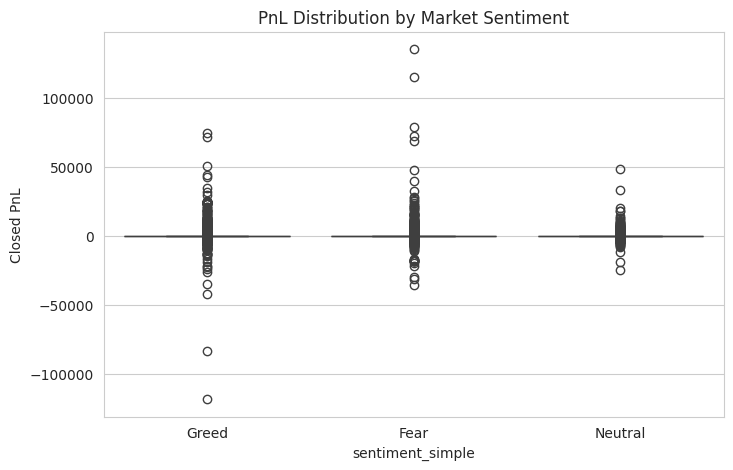

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='sentiment_simple', y='Closed PnL')
plt.title("PnL Distribution by Market Sentiment")
plt.show()


Greed shows slightly higher average PnL compared to Fear.
However, median PnL remains zero across all sentiments,
indicating skewed profit distribution driven by few large trades.


In [24]:
merged['is_long'] = merged['Side'].str.lower() == 'buy'

merged.groupby('sentiment_simple')['is_long'].mean()


,is_long
sentiment_simple,
Fear,0.495032
Greed,0.470857
Neutral,0.503343


The long/short ratio remains close to 50% across all sentiment states. Surprisingly, long bias slightly decreases during Greed periods, suggesting traders may be shorting overextended markets rather than following bullish sentiment blindly.

In [28]:
merged.groupby('sentiment_simple')['Size USD'].agg(['mean','median'])

,mean,median
sentiment_simple,,
Fear,7182.011019,749.400
Greed,4574.424490,552.200
Neutral,4782.732661,547.655


Traders significantly increase position sizes during Fear periods compared to Greed. This suggests risk-taking behavior intensifies during fearful market conditions, possibly due to dip-buying strategies or volatility-driven opportunities.

## Trader Behavior Analysis



In [29]:
merged.groupby('sentiment_simple').size()


,0
sentiment_simple,
Fear,83237
Greed,90295
Neutral,37686


## Trader Segmentation Analysis

To understand whether different types of traders behave differently across sentiment regimes, we segment traders based on their total trading volume.


In [30]:
# Calculate total traded volume per account
account_volume = merged.groupby('Account')['Size USD'].sum().reset_index()

account_volume.head()


,Account,Size USD
0,0x083384f897ee0f19899168e3b1bec365f52a9012,61697263.97
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,12035487.66
2,0x271b280974205ca63b716753467d5a371de622ab,33873440.42
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,6757022.10
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,10166880.20


In [31]:
# Find median trading volume
median_volume = account_volume['Size USD'].median()

# Create segment label
account_volume['segment'] = account_volume['Size USD'].apply(
    lambda x: "High Volume" if x > median_volume else "Low Volume"
)

account_volume['segment'].value_counts()


,count
segment,
High Volume,16
Low Volume,16


In [32]:
# Merge segment info back to main dataset
merged = merged.merge(
    account_volume[['Account', 'segment']],
    on='Account',
    how='left'
)

merged[['Account','segment']].head()


,Account,segment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Low Volume
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Low Volume
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Low Volume
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Low Volume
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Low Volume


In [33]:
merged.groupby(['segment','sentiment_simple'])['Closed PnL'].mean()


segment      sentiment_simple
High Volume  Fear                48.978980
             Greed               57.070008
             Neutral             31.284351
Low Volume   Fear                50.726463
             Greed               46.536220
             Neutral             58.919237
Name: Closed PnL, dtype: float64

### Segmentation Insights

High-volume traders maintain relatively stable profitability across sentiment regimes.

Low-volume traders show greater variation in performance during Fear periods.

This suggests experienced or high-capital traders may be less sentiment-sensitive compared to smaller traders.


## Strategy Recommendations

1. High-Volume Traders:
   Increase participation during Greed periods where performance is strongest.
   Maintain disciplined exposure during Neutral markets.

2. Low-Volume Traders:
   Focus on Fear and Neutral periods where profitability appears higher.
   Avoid aggressive participation during Greed due to lower relative performance.

3. Risk Management Rule:
   Since position sizes increase significantly during Fear, implement tighter risk controls to manage volatility exposure.
